In [ ]:
import pandas as pd
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

dir_suffix = "data/"
dir_suffix_entpackt = dir_suffix + "Daten_ausgepackt/"

In [ ]:
print("Tip25W Testdaten Template:")
testdata = pd.read_csv(dir_suffix+"tip25W_testdaten_template.csv")

display(testdata.head(12))

print("Tip25W Trainingsdaten:")
trainingdata = pd.read_csv(dir_suffix+"tip25W_trainingsdaten.csv")
# ist das gleiche wie orders gefiltert nach nur prior und das gleiche wie der prior Datensatz
#trainingdata = trainingdata[:300000]
display(trainingdata.head(11))

print("Prior:")
df_orders_prior = pd.read_csv(dir_suffix_entpackt+ "order_products__prior.csv")
display(df_orders_prior.head(10))

print("train:")
df_orders_train = pd.read_csv(dir_suffix_entpackt + "order_products__train.csv")
display(df_orders_train)

print("orders")
df_orders = pd.read_csv(dir_suffix_entpackt + "orders.csv")
display(df_orders.head(10))

print("products:")
df_products = pd.read_csv(dir_suffix_entpackt + "products.csv")
display(df_products.head(10))



Tip25W Testdaten Template:


,Unnamed: 0,order_id,tip,tip_pc
0,10,1187899,NaN,NaN
1,25,1492625,NaN,NaN
2,49,2196797,NaN,NaN
3,74,525192,NaN,NaN
4,78,880375,NaN,NaN
5,82,1094988,NaN,NaN
6,88,1822501,NaN,NaN
7,115,1827621,NaN,NaN
8,129,2316178,NaN,NaN
9,200,2180313,NaN,NaN


Tip25W Trainingsdaten:


,Unnamed: 0,order_id,tip,tip_pc
0,0,2539329,True,0.092177
1,1,2398795,False,0.000000
2,2,473747,False,0.000000
3,3,2254736,True,0.102231
4,4,431534,True,0.092990
5,5,3367565,False,0.000000
6,6,550135,False,0.000000
7,7,3108588,False,0.000000
8,8,2295261,False,0.000000
9,9,2550362,False,0.000000


Prior:


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


train:


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


orders


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


products:


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [ ]:

"""
große Tablle erzeugen die alle basis Informationen enthält und die Verbindung zwischen User seinen Orders und dessen Inhalt
"""

merged = trainingdata.merge(df_orders_prior, on="order_id", how="left")
merged = merged.merge(df_orders, on="order_id", how="left")

"""Wir benötigen numerische Werte desswegen werden die nan ersetzt"""

merged = merged.fillna(0)

In [ ]:
"""erstellung der Features pro User pro order 
    eine Zeile Pro Bestellung
"""
order_features = (
    df_orders_prior
    .groupby("order_id")
    .agg(
        num_products=("product_id", "count"),
        num_reordered=("reordered", "sum")
    )
    .reset_index()
)


"""Zugehörigkeit der Bestellungen zu den jeweiligen Departments der Bestellung """
prior_with_dept = df_orders_prior.merge(
    df_products[["product_id", "department_id"]],
    on="product_id",
    how="left"
)

"""Wie viele Produkte wurden in der jeweiligen Bestellung aus welchem Department bestellt """
dept_counts = (
    prior_with_dept
    .groupby(["order_id", "department_id"])
    .size()
    .unstack(fill_value=0)
)


""" hier werden die Departments one hot encoded aber als wert ist der Item Count pro Departmetn der Bestellung enthalten (wird später zu Anteilen geändert)"""

dept_counts.columns = [f"department_id_{int(c)}" for c in dept_counts.columns]
dept_counts = dept_counts.reset_index()

order_features = order_features.merge(
    dept_counts,
    on="order_id",
    how="left"
)

""" Hier werden die bisherigen Werte und DF mit den orders und den Trainigsdaten vereint um die Daten zu zentralisieren"""

order_features = order_features.merge(
    df_orders,
    on="order_id",
    how="left"
)
""" final_df ist der DF auf dem wir arbeiten können um features zu erstellen"""
final_df = order_features.merge(
    trainingdata[["order_id", "tip", "tip_pc"]],
    on="order_id",
    how="left"
)

""" Hier werden die Zyklischen Features wie Day Of Week und Order Hour encoded

    One Hot encoding wurde auch versucht hat aber zu minimal schlechteren Ergebnissen geführt
    Da Stunden des Tages ein 24h Zyklus sind setzt man die Werte in den Einheitskreis um so zu verhuindern dass stunde 23 wichtiger erscheint wie Stunde 3 (id Problem)
"""
#Cycle Encode

final_df["order_dow_sin"] = np.sin(2 * np.pi * final_df["order_dow"] / 7)
final_df["order_dow_cos"] = np.cos(2 * np.pi * final_df["order_dow"] / 7)

# Stunde (0–23)
final_df["order_hour_sin"] = np.sin(2 * np.pi * final_df["order_hour_of_day"] / 24)
final_df["order_hour_cos"] = np.cos(2 * np.pi * final_df["order_hour_of_day"] / 24)


#One Hot
""" df_day_encoded = pd.get_dummies(final_df, columns=["order_dow"], prefix="dow",drop_first=False)
df_day_encoded

df_encoded_final = pd.get_dummies(df_day_encoded, columns=["order_hour_of_day"], prefix="hour",drop_first=False)
df_encoded_final
df_encoded_final.head(10) """


' df_day_encoded = pd.get_dummies(final_df, columns=["order_dow"], prefix="dow",drop_first=False)\ndf_day_encoded\n\ndf_encoded_final = pd.get_dummies(df_day_encoded, columns=["order_hour_of_day"], prefix="hour",drop_first=False)\ndf_encoded_final\ndf_encoded_final.head(10) '

In [ ]:

df = final_df.copy()
#sortiere die Orders pro user 
df = df.sort_values(["user_id", "order_number"]).reset_index(drop=True)

""" vorherige Tip des Users immer die letzte nicht die neuste um leakage zu verhindern"""
#hat der user in seiner letzten Bestellung ein Tip gegeben oder nicht
tip_past = df.groupby("user_id")["tip"].shift(1).astype("float")
df["tip_last_order"] = tip_past.fillna(0).astype(int)


""" vorherige Tip Prozent des Users """
# wie viel % hat der User in seiner letzten Bestellung getipt 
tip_past_pc = df.groupby("user_id")["tip_pc"].shift(1).astype("float")
df["tip_last_order_pc"] = (tip_past_pc * 100).fillna(0).round(0).astype(int)


""" features für User Tip und Tip PC berechnen /agg"""
#summe seiner vergangenen Tip Pc über alle seine Bestellungen
df["tips_past_pc"] = df["tip_last_order_pc"].groupby(df["user_id"]).cumsum()

# summe der Orders in der Vergangenheit bei denen er ein Tip gegeben hat
df["tips_past"] = df["tip_last_order"].groupby(df["user_id"]).cumsum()

# Wie viele Bestellungen hatte der User bisher
df["orders_past"] = tip_past.groupby(df["user_id"]).cumcount()

# Anteil der vergangenen Orders bei denen getipt wurde pre User
df["tip_rate_past"] = (df["tips_past"] / df["orders_past"]).where(df["orders_past"] > 0, 0.0)

# Durchschnittliche Tip PC über alle vergangenen Orders
df["tip_rate_past_pc"] = (df["tips_past_pc"] / df["orders_past"]).where(df["orders_past"] > 0, 0.0)


""" wie viele Tips hat der User in seinen vorhergehenden 3 Bestellungen gegeben"""
tips_3 = (
    tip_past
    .groupby(df["user_id"])
    .rolling(window=3, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

# teilwert wie viele vergangene werden betrachtet 
# bei 0rder 1  = 0
# bei Order 2 = 1
# bei Order 3 = 2
# ab Order 4 = 3 immer 3 wegen Window
orders_3 = (
    tip_past
    .groupby(df["user_id"])
    .rolling(window=3, min_periods=1)
    .count()
    .reset_index(level=0, drop=True)
)

# wie hoch war die Tip Rate beim User in den letzten 3 Bestellungen 
df["tip_rate_past_3"] = (tips_3 / orders_3).where(orders_3 > 0, 0.0)
# Der Anteil wie viele PRodukte sind wiederbestellungen 
df["reorder_ratio"] = (df["num_reordered"] / df["num_products"].replace(0, 1)) * 100

df.head(20)

,order_id,num_products,num_reordered,department_id_1,department_id_2,department_id_3,department_id_4,department_id_5,department_id_6,department_id_7,...,order_hour_cos,tip_last_order,tip_last_order_pc,tips_past_pc,tips_past,orders_past,tip_rate_past,tip_rate_past_pc,tip_rate_past_3,reorder_ratio
0,2539329,5,0,0,0,0,0,0,0,1,...,-0.500000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
1,2398795,6,3,0,0,0,1,0,0,1,...,-0.258819,1,9,9,1,1,1.000000,9.000000,1.000000,50.000000
2,473747,5,3,0,0,0,0,0,0,1,...,-1.000000,0,0,9,1,2,0.500000,4.500000,0.500000,60.000000
3,2254736,5,5,0,0,0,0,0,0,1,...,-0.258819,0,0,9,1,3,0.333333,3.000000,0.333333,100.000000
4,431534,8,5,0,0,0,4,0,0,1,...,-0.707107,1,10,19,2,4,0.500000,4.750000,0.333333,62.500000
5,3367565,4,4,0,0,0,0,0,0,1,...,-0.258819,1,9,28,3,5,0.600000,5.600000,0.666667,100.000000
6,550135,5,5,0,0,0,0,0,0,1,...,-0.707107,0,0,28,3,6,0.500000,4.666667,0.666667,100.000000
7,3108588,6,4,0,0,0,0,0,0,2,...,-0.866025,0,0,28,3,7,0.428571,4.000000,0.333333,66.666667
8,2295261,6,6,0,0,0,0,0,0,2,...,-0.500000,0,0,28,3,8,0.375000,3.500000,0.000000,100.000000
9,2550362,9,6,0,0,0,0,0,0,2,...,-0.500000,0,0,28,3,9,0.333333,3.111111,0.000000,66.666667


In [ ]:
df[[
    "num_products",
    "tip_pc",
    "orders_past",
    "tip_rate_past_pc"
]].describe(percentiles=[.01, .05, .95, .99])

,num_products,tip_pc,orders_past,tip_rate_past_pc
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06
mean,1.008888e+01,7.790044e-02,1.619107e+01,7.323707e+00
std,7.525398e+00,6.578102e-02,1.779950e+01,5.236399e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+00,1.023381e-01,1.000000e+01,7.588235e+00
95%,2.500000e+01,1.638294e-01,5.400000e+01,1.500000e+01
99%,3.500000e+01,1.806936e-01,8.100000e+01,1.600000e+01
max,1.450000e+02,2.386808e-01,9.800000e+01,2.300000e+01


In [ ]:
df = df.drop(["order_id", "user_id","eval_set", "order_dow", "order_hour_of_day"],axis=1)
display(df)

,num_products,num_reordered,department_id_1,department_id_2,department_id_3,department_id_4,department_id_5,department_id_6,department_id_7,department_id_8,...,order_hour_cos,tip_last_order,tip_last_order_pc,tips_past_pc,tips_past,orders_past,tip_rate_past,tip_rate_past_pc,tip_rate_past_3,reorder_ratio
0,5,0,0,0,0,0,0,0,1,0,...,-5.000000e-01,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
1,6,3,0,0,0,1,0,0,1,0,...,-2.588190e-01,1,9,9,1,1,1.000000,9.000000,1.000000,50.000000
2,5,3,0,0,0,0,0,0,1,0,...,-1.000000e+00,0,0,9,1,2,0.500000,4.500000,0.500000,60.000000
3,5,5,0,0,0,0,0,0,1,0,...,-2.588190e-01,0,0,9,1,3,0.333333,3.000000,0.333333,100.000000
4,8,5,0,0,0,4,0,0,1,0,...,-7.071068e-01,1,10,19,2,4,0.500000,4.750000,0.333333,62.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214869,3,3,0,0,0,0,0,0,1,0,...,-7.071068e-01,0,0,17,2,8,0.250000,2.125000,0.000000,100.000000
3214870,9,3,1,0,1,1,0,0,1,0,...,-1.836970e-16,1,8,25,3,9,0.333333,2.777778,0.333333,33.333333
3214871,8,6,0,0,1,1,0,0,1,0,...,-8.660254e-01,0,0,25,3,10,0.300000,2.500000,0.333333,75.000000
3214872,20,14,0,0,2,5,0,0,1,0,...,-1.000000e+00,0,0,25,3,11,0.272727,2.272727,0.333333,70.000000


In [ ]:
""" dept_cols = [c for c in df.columns if c.startswith("department_id_")]


# Anzahl der Bestellungen Pro Department
dep_tip_count = (
    df[dept_cols].gt(0)
    .astype(int)
    .sum()
)

# Durchschnittliche Tip im Department 
avg_tip_per_dept = (
    df[dept_cols].gt(0)
    .astype(int)
    .multiply(df["tip_pc"], axis=0)
    .sum()
    /df[dept_cols].sum()
    #dep_tip_count
)

for elem in dept_cols:
    df[elem.replace("department_id_", "dept_share_")] = df[elem] / df["num_products"]
df.drop(columns=dept_cols, inplace=True)

 """
 
 
dept_cols = [c for c in df.columns if c.startswith("department_id_")]

# ---------------------------------------------------
# 2) Department-SHARES pro Order bauen (WICHTIG: ZUERST!)
# ---------------------------------------------------
for elem in dept_cols:
    df[elem.replace("department_id_", "dept_share_")] = (
        df[elem] / df["num_products"].replace(0, 1)
    )

dept_share_cols = [
    c.replace("department_id_", "dept_share_") for c in dept_cols
]

# ---------------------------------------------------
# 3) Wie oft kommt ein Department vor (Orders mit Dept > 0)
# ---------------------------------------------------
dep_order_count = (
    df[dept_cols]
    .gt(0)
    .astype(int)
    .sum()
)

# ---------------------------------------------------
# 4) Durchschnittlicher Tip pro Department (binär: Dept ja/nein)
# ---------------------------------------------------
avg_tip_per_dept = (
    df[dept_cols]
    .gt(0)
    .astype(int)
    .multiply(df["tip_pc"], axis=0)
    .sum()
    / dep_order_count.replace(0, np.nan)
)

# ---------------------------------------------------
# 5) Durchschnittlicher Tip pro Department-SHARE (gewichteter Ansatz)
# ---------------------------------------------------
avg_tip_per_dept_share = (
    df[dept_share_cols]
    .multiply(df["tip_pc"], axis=0)
    .sum()
    / df[dept_share_cols].sum().replace(0, np.nan)
)

# ---------------------------------------------------
# 6) Optional: alte Count-Spalten droppen
# ---------------------------------------------------
df.drop(columns=dept_cols, inplace=True)

KeyError: "None of [Index(['dept_share_1', 'dept_share_2', 'dept_share_3', 'dept_share_4',\n       'dept_share_5', 'dept_share_6', 'dept_share_7', 'dept_share_8',\n       'dept_share_9', 'dept_share_10', 'dept_share_11', 'dept_share_12',\n       'dept_share_13', 'dept_share_14', 'dept_share_15', 'dept_share_16',\n       'dept_share_17', 'dept_share_18', 'dept_share_19', 'dept_share_20',\n       'dept_share_21'],\n      dtype='object')] are in the [columns]"

In [ ]:
display(merged.head(1))

order_df = df

,Unnamed: 0,order_id,tip,tip_pc,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,2539329,True,0.092177,196,1,0,1,prior,1,2,8,0.0


In [ ]:



#X["is_first_order"] = (X["order_number"] == 1).astype(int)
#X["days_since_prior_order"] = X["days_since_prior_order"].fillna(0)
#X.head(10)

order_df.head(3)


single = order_df.tail(1) 
order_df =  order_df.iloc[:-1].copy() 

order_df = order_df.fillna(0)



In [ ]:
X_base = order_df.drop(columns=["tip", "tip_pc"])
y_tip = order_df["tip"].astype(int)
y_tip_pc = order_df["tip_pc"]

X_train, X_test, y_tip_train, y_tip_test, y_pc_train, y_pc_test = train_test_split(
    X_base, y_tip, y_tip_pc,
    test_size=0.2,
    random_state=42
)
X_train_base = X_train.copy()
X_test_base  = X_test.copy()


In [ ]:
X_train.head(3)
X_test

,num_products,num_reordered,order_number,days_since_prior_order,order_dow_sin,order_dow_cos,order_hour_sin,order_hour_cos,tip_last_order,tip_last_order_pc,...,dept_share_12,dept_share_13,dept_share_14,dept_share_15,dept_share_16,dept_share_17,dept_share_18,dept_share_19,dept_share_20,dept_share_21
737360,3,3,82,2.0,0.433884,-0.900969,1.224647e-16,-1.000000e+00,1,14,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
1215397,5,4,14,2.0,0.974928,-0.222521,-7.071068e-01,-7.071068e-01,1,13,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.200000,0.000000,0.000000
2209486,10,9,65,5.0,0.974928,-0.222521,-5.000000e-01,-8.660254e-01,1,16,...,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000
778849,19,16,39,5.0,0.000000,1.000000,-7.071068e-01,-7.071068e-01,1,17,...,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000
621365,14,14,69,2.0,0.433884,-0.900969,0.000000e+00,1.000000e+00,1,15,...,0.000000,0.071429,0.142857,0.071429,0.071429,0.214286,0.000000,0.142857,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789837,9,6,85,4.0,-0.974928,-0.222521,-2.588190e-01,-9.659258e-01,1,15,...,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.111111
1293193,39,36,30,0.0,-0.433884,-0.900969,-5.000000e-01,-8.660254e-01,1,16,...,0.000000,0.025641,0.000000,0.000000,0.205128,0.000000,0.000000,0.461538,0.051282,0.000000
2885702,24,15,5,30.0,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0,0,...,0.041667,0.041667,0.000000,0.000000,0.041667,0.000000,0.000000,0.208333,0.041667,0.000000
1728032,29,29,27,9.0,0.974928,-0.222521,9.659258e-01,-2.588190e-01,0,0,...,0.000000,0.068966,0.034483,0.034483,0.103448,0.034483,0.068966,0.103448,0.034483,0.000000


In [ ]:
from sklearn.metrics import accuracy_score


log_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=2000))
    ]
)

log_pipeline.fit(X_train, y_tip_train)
y_pred_log  = log_pipeline.predict(X_test)

print("LogReg Accuracy:", accuracy_score(y_tip_test, y_pred_log))

LogReg Accuracy: 0.7686224192231425


In [ ]:
X_train = X_train.copy()
X_train["tip_hat"] = log_pipeline.predict(X_train)
X_test = X_test.copy()
X_test["tip_hat"] = log_pipeline.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("linreg", LinearRegression())
    ]
)

reg_pipeline.fit(X_train, y_pc_train)

y_pc_pred = reg_pipeline.predict(X_test)

#y_pc_pred[X_test["tip_hat"] == 0] = 0.0
print("MAE:", mean_absolute_error(y_pc_test, y_pc_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_pc_test, y_pc_pred)))
print("R²:", r2_score(y_pc_test, y_pc_pred))

MAE: 0.03956692673295421
RMSE: 0.04902236533368894
R²: 0.4444163566108178


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = log_pipeline.named_steps["scaler"]
log_model = log_pipeline.named_steps["logreg"]

X_train_scaled = scaler.transform(X_train_base)
X_test_scaled  = scaler.transform(X_test_base)

import shap

explainer = shap.LinearExplainer(
    log_model,
    X_train_scaled,
    feature_names=X_train_base.columns
)

shap_values = explainer(X_test_scaled)


ModuleNotFoundError: No module named 'shap'

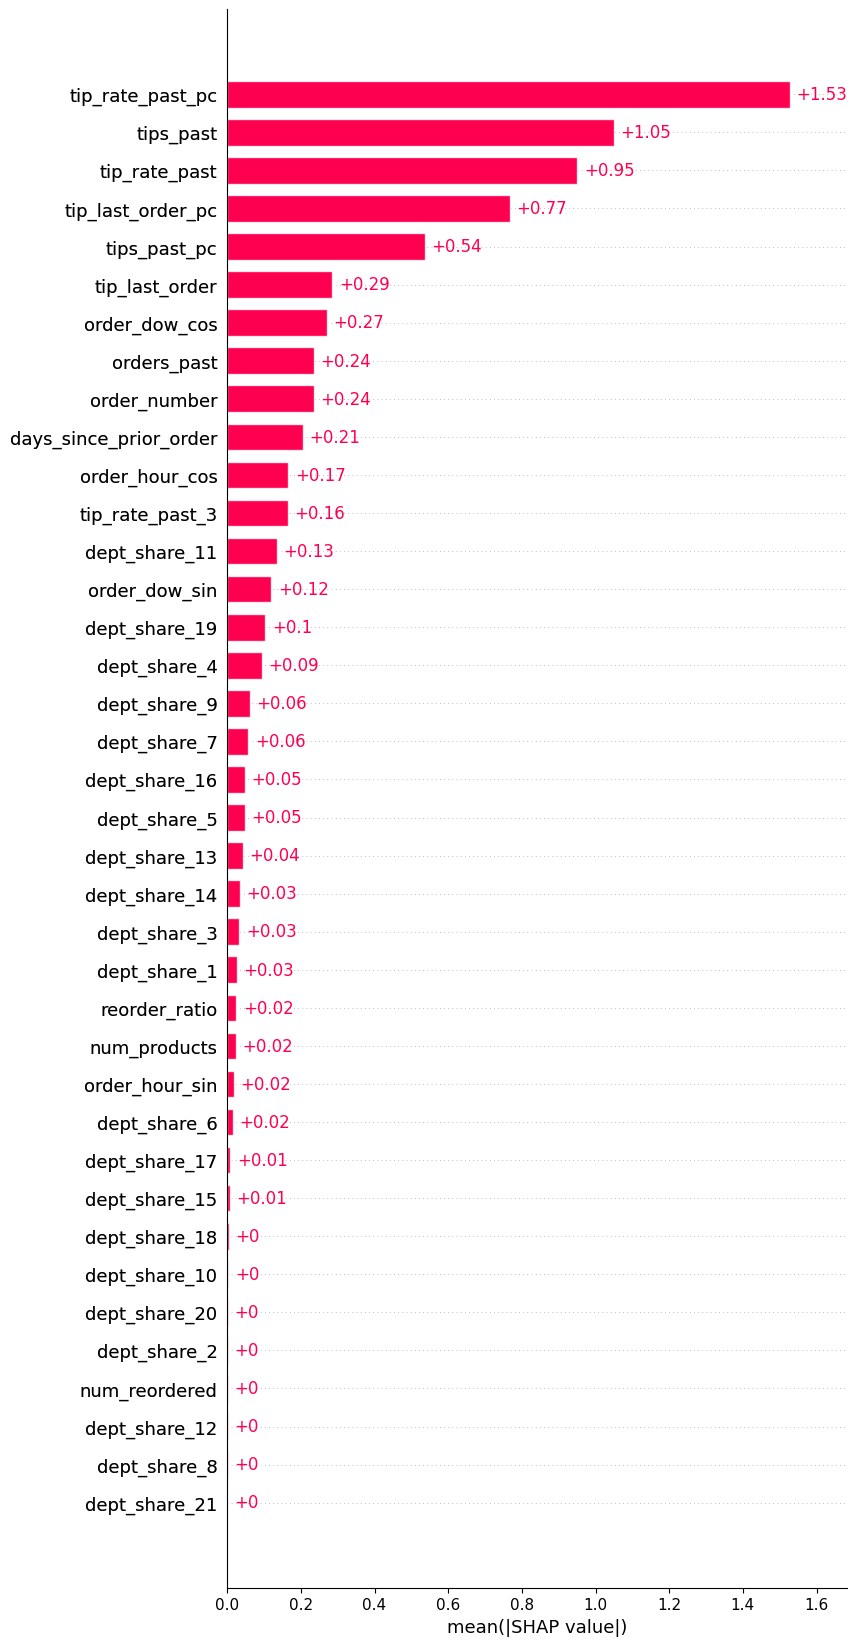

In [ ]:
shap.plots.bar(shap_values, max_display=38)

In [ ]:
X_corr = X_train_base.select_dtypes(include=[np.number])

corr_matrix = X_corr.corr(method="pearson")

In [ ]:
list(X_train_base.columns)


['num_products',
 'num_reordered',
 'order_number',
 'days_since_prior_order',
 'order_dow_sin',
 'order_dow_cos',
 'order_hour_sin',
 'order_hour_cos',
 'tip_last_order',
 'tip_last_order_pc',
 'tips_past_pc',
 'tips_past',
 'orders_past',
 'tip_rate_past',
 'tip_rate_past_pc',
 'tip_rate_past_3',
 'reorder_ratio',
 'dept_share_1',
 'dept_share_2',
 'dept_share_3',
 'dept_share_4',
 'dept_share_5',
 'dept_share_6',
 'dept_share_7',
 'dept_share_8',
 'dept_share_9',
 'dept_share_10',
 'dept_share_11',
 'dept_share_12',
 'dept_share_13',
 'dept_share_14',
 'dept_share_15',
 'dept_share_16',
 'dept_share_17',
 'dept_share_18',
 'dept_share_19',
 'dept_share_20',
 'dept_share_21']

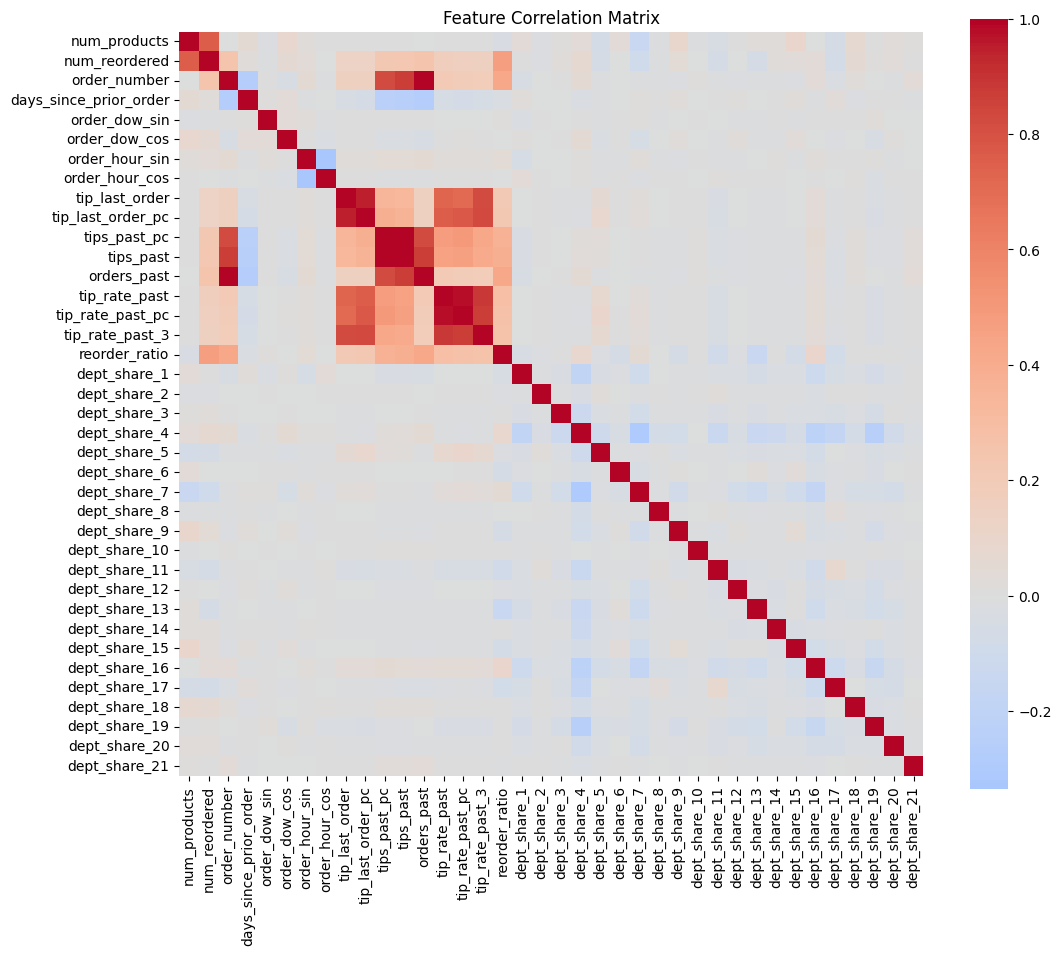

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Feature Correlation Matrix")
plt.show()
